In [1]:
from os import chdir
chdir('..')

In [24]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib notebook
sns.set()

In [58]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df_all_section = df[df.section == 'all']
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,points,section,shape,time
0,polylidar,2000,delaunay,migloveholes,0.950
1,polylidar,2000,mesh,migloveholes,0.997
2,polylidar,2000,polygon,migloveholes,0.654
3,polylidar,2000,all,migloveholes,2.601
4,cgal,2000,all,migloveholes,6.224


<IPython.core.display.Javascript object>


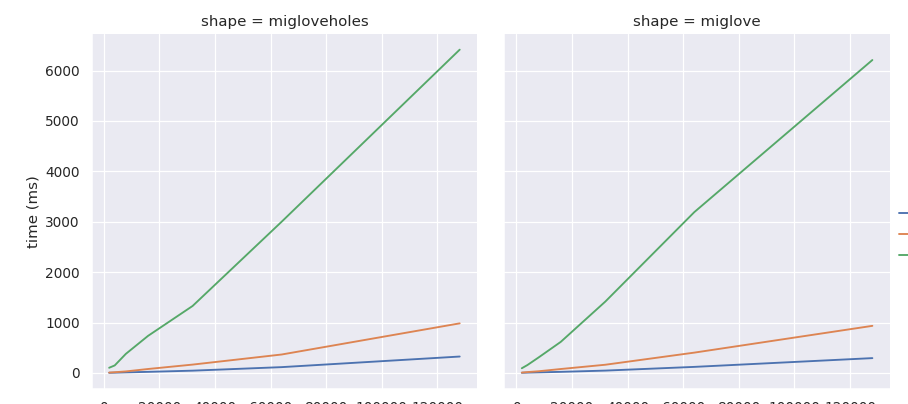

In [59]:
g = sns.relplot(x="points", y="time", hue="alg",
            facet_kws=dict(sharex=True),col="shape",
            kind="line", legend="full", data=df_all_section)
g.set_ylabels("time (ms)")
g.set_xlabels("# Points")
# g.set(yscale="log")

<IPython.core.display.Javascript object>


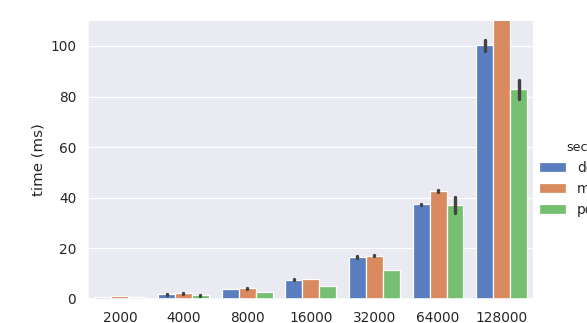

In [60]:
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted", 
                hue_order=["delaunay", "mesh", "polygon"], facet_kws=dict(ylim=[0.01, 110]), height=4, aspect=1.5)

g.set_ylabels("time (ms)")
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")